In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
plt.set_cmap('gray')
plt.rcParams['figure.figsize'] = (12, 10)

import numpy as np
import SimpleITK as sitk

import subtle.utils.io as suio
import subtle.utils.experiment as exp_utils
import subtle.subtle_preprocess as sup
import subtle.subtle_preprocess as supre

from skimage.morphology import binary_closing
from skimage import color

import os
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from glob import glob
import pydicom

def get_rgb(img):
    img = (img - np.min(img))/np.ptp(img)
    return np.dstack((img, img, img))

def overlay_rgb(base_vol, ovr_vol, sl_idx, ch_idx=0, alpha=0.5):
    img_a = get_rgb(base_vol[sl_idx])
    img_b = get_rgb(ovr_vol[sl_idx])
    
    img_a[..., ch_idx] = img_b[..., 0] * alpha
    return img_a
    
def slice_preview(img_vol, interval=7, disp=True):
    n_rows = 7
    n_cols = 6
    idx = interval
    all_imgs = []
    bflag = False
    for c in range(n_cols):
        img_rows = []
        for r in range(n_rows):
            if idx >= img_vol.shape[0]:
                img_rows.append(np.zeros_like(img_vol[0]))
                bflag = True
            else:
                img_rows.append(img_vol[idx])
            idx += interval
                
        all_imgs.append(np.hstack(img_rows))
        if bflag:
            break
    
    img_disp = np.vstack(all_imgs)
    
    if not disp:
        return img_disp
    
    plt.imshow(img_disp)
    plt.axis('off')
    plt.show()

def get_dicom_vol(dirpath_dicom):
    dcm_files = sorted([f for f in glob('{}/*.dcm'.format(dirpath_dicom))])
    return np.array([pydicom.dcmread(f).pixel_array for f in dcm_files])

<Figure size 432x288 with 0 Axes>

In [26]:
base_path = '/home/srivathsa/projects/studies/gad/tiantan/data/Case1/3DFLAIR-VISTA-SAG_CS7_Series0401'
flair_vol, hdr = suio.dicom_files(base_path)

flair_spacing = np.array([float(hdr.PixelSpacing[0]), float(hdr.PixelSpacing[1]), float(hdr.SliceThickness)])

data_full = suio.load_file('/home/srivathsa/projects/studies/gad/tiantan/preprocess/data/Case1.h5', params={'h5_key': 'all'})
t1_pre = data_full[0, :, 0]
t1_meta = suio.load_h5_metadata('/home/srivathsa/projects/studies/gad/tiantan/preprocess/data/Case1_meta.h5')

In [55]:
pmap = sitk.GetDefaultParameterMap('affine')
ref_fixed = supre.dcm_to_sitk('/home/srivathsa/projects/studies/gad/tiantan/data/Case1/3DT1W-MPRAGE_SAG_CS4_301')

ref_moving = supre.dcm_to_sitk(base_path)

fixed_spacing = t1_meta['pixel_spacing_zero']
flair_reg, reg_params = supre.register_im(t1_pre, flair_vol, param_map=pmap, im_fixed_spacing=fixed_spacing, 
                                       im_moving_spacing=flair_spacing, ref_fixed=ref_fixed, ref_moving=ref_moving)

flair_sc = np.interp(flair_reg, (flair_reg.min(), flair_reg.max()), (t1_pre.min(), t1_pre.max()))

nse_mask = supre.mask_im(np.array([flair_reg]))[0]
flair_sc = nse_mask * flair_sc

mask = data_full[1, :, 2] > 0.1
mask = binary_closing(mask)

flair_m = flair_sc * mask

image registration
registration done, 4.19 s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


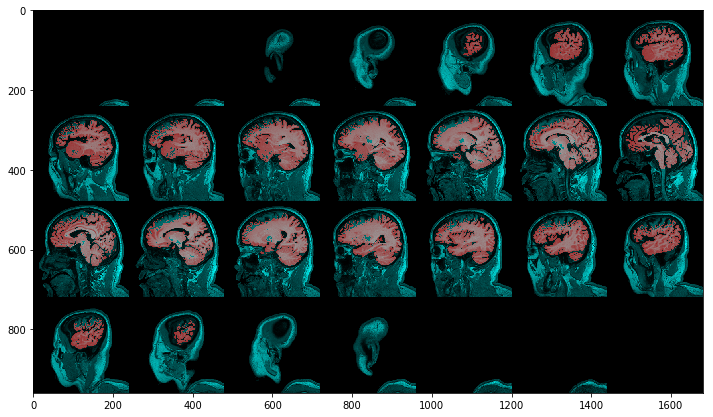

In [65]:
th = np.quantile(flair_m, 0.9)
flair_th = (flair_m >= th).astype(t1_pre.dtype)

t1_disp = slice_preview(t1_pre, disp=False)
csf_disp = slice_preview(flair_th, disp=False)

t1_rgb = get_rgb(t1_disp)
csf_rgb = get_rgb(csf_disp)

t1_rgb[..., 0] = csf_rgb[..., 0] * 0.5

disp_scale = 1.2
plt.imshow(disp_scale * t1_rgb, vmin=t1_pre.min(), vmax=t1_pre.max())

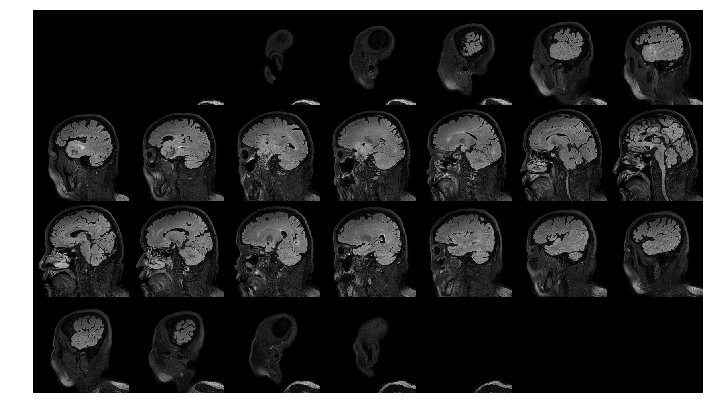

In [69]:
slice_preview(flair_sc)